# Stage 4a: Demonstrate using AI Alpha and Daily Betas to produce optiomal weights

In [1]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

# Set the import path for the tools directiory
import sys
# insert at position 1 in the path, as 0 is the path of this file.
sys.path.insert(1, '../tools')
import importlib
import ameritrade_functions as amc
importlib.reload(amc)
import utils
importlib.reload(utils)
import trading_factors as alpha_factors
importlib.reload(alpha_factors)

print(f'Python version : {python_version()}')
print(f'Pandas version : {pd.__version__}')

Python version : 3.8.10
Pandas version : 0.25.3


## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [2]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

# For Chromedriver
from pathlib import Path
chrome_executabel_path = str(Path.home()) + r'\Anaconda Projects\chromedriver\chromedriver'

# Make sure we have a data directory
Path('./data').mkdir(parents=True, exist_ok=True) 

masked_account_number = '#---9216'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = 'data/price_histories.csv'

In [3]:
td_ameritrade = amc.AmeritradeRest(username, password, client_id, chrome_executabel_path)
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    print('Error: No authorization data: {}'.format(td_ameritrade.authorization))
else:
    print('You have authorization')

You have authorization


# Gather Data

- Current Holdings
- Price Histories
- AI Alpha
- Daily Beta

## First lets see why stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

In [4]:
# Specific Portfolio Account
account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')

# Filter out non Equity investments
current_stocks = amc.AmeritradeRest(username, password, client_id).get_quotes(utils.get_investment_symbols(equity_investments_df)).query('assetType == "EQUITY"').index.tolist()
current_investments_df = equity_investments_df[equity_investments_df['symbol'].isin(current_stocks)]
current_investments_df

,account,shortQuantity,averagePrice,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,currentDayCost,previousSessionLongQuantity,assetType,cusip,symbol,description,type
8,#---9216,0.0,352.96000,2.920000,0.38,2.0,2.0,0.0,772.82,231.85,0.0,2.0,EQUITY,244199105,DE,0,0
9,#---9216,0.0,44.01929,-6.090000,-0.88,14.0,14.0,0.0,686.21,205.86,0.0,14.0,EQUITY,46284V101,IRM,0,0
10,#---9216,0.0,68.24000,0.539964,0.09,9.0,9.0,0.0,581.94,174.58,0.0,9.0,EQUITY,90184L102,TWTR,0,0
11,#---9216,0.0,311.60000,7.000000,1.04,2.0,2.0,0.0,682.42,204.73,0.0,2.0,EQUITY,482480100,KLAC,0,0
12,#---9216,0.0,304.55500,-7.460000,-1.26,2.0,2.0,0.0,582.30,174.69,0.0,2.0,EQUITY,701094104,PH,0,0
14,#---9216,0.0,661.64000,0.680000,0.09,1.0,1.0,0.0,733.07,293.23,0.0,1.0,EQUITY,88160R101,TSLA,0,0
15,#---9216,0.0,47.42000,-0.520000,-0.09,13.0,13.0,0.0,596.96,179.09,0.0,13.0,EQUITY,125269100,CF,0,0
16,#---9216,0.0,255.11000,-2.640000,-0.47,2.0,2.0,0.0,553.20,165.96,0.0,2.0,EQUITY,294429105,EFX,0,0
17,#---9216,0.0,0.21397,57.000000,8.23,5000.0,5000.0,0.0,750.00,0.00,0.0,5000.0,EQUITY,Q3860H107,FGPHF,0,0


In [5]:
price_histories = utils.read_price_histories(price_histories_file_name)
print(f'Date range for price histories: {price_histories.date.min().date()} to {price_histories.date.max().date()}')
pricing = utils.get_close_values(price_histories)
print(f'You have {len(pricing.columns)} stocks from picing')

alpha_vectors = pd.read_csv('data/alpha_vectors.csv', parse_dates=['date']).set_index(['date']).sort_index()
print(f'You have {len(alpha_vectors.columns)} stocks from alpha')

with open('data/daily_beta.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    daily_betas = pickle.load(f)
print(f'You have {len(daily_betas)} of daily betas')

Date range for price histories: 2016-09-02 to 2021-09-02
You have 436 stocks from picing
You have 436 stocks from alpha
You have 253 of daily betas


In [6]:
alpha_vectors[list(daily_betas.keys())[0]:]

,A,AAL,AAP,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,...,WYNN,XEL,XLNX,XOM,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2020-09-02,-0.015105,-0.006373,0.030736,0.011116,-0.014020,-0.013407,0.030142,0.023179,-0.016267,0.011168,...,-0.004080,-0.025508,-0.002402,0.004709,-0.018217,-0.015298,0.003240,0.001232,0.038770,0.007072
2020-09-03,-0.014584,-0.006265,-0.005446,0.003839,0.030946,-0.013596,0.018489,0.016434,-0.019695,0.013513,...,0.008311,-0.026865,0.007381,-0.001059,-0.011526,-0.020354,0.012493,0.027291,0.037465,0.011432
2020-09-04,0.002757,-0.006208,-0.016284,-0.017620,0.031124,-0.004112,0.034351,-0.016107,-0.016929,0.006042,...,0.034555,-0.025380,0.013649,0.006113,-0.006458,-0.013218,0.017158,0.024920,-0.002971,0.012968
2020-09-08,0.002905,-0.010743,-0.008823,-0.011852,0.028231,-0.015375,0.028428,-0.018334,-0.014009,-0.004135,...,0.026259,-0.019891,0.016340,-0.003570,-0.025736,-0.013865,0.004558,0.028001,0.003216,0.014091
2020-09-09,-0.011142,-0.000108,-0.009592,-0.032756,0.006910,-0.020480,0.010745,-0.019775,-0.018197,-0.009378,...,0.015539,-0.022874,0.015963,-0.000561,-0.016963,-0.006237,-0.002617,0.031455,0.008116,0.004781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,-0.008171,-0.012168,0.014063,-0.002390,0.000300,-0.022408,-0.013032,0.006334,-0.018844,0.015091,...,-0.003381,0.026656,-0.008952,-0.018115,-0.003670,0.004571,-0.000558,-0.003822,-0.025020,0.030932
2021-08-30,-0.015271,-0.001932,0.009862,-0.002133,-0.012815,-0.015818,-0.007866,0.019839,-0.019360,0.029172,...,-0.001204,-0.003720,-0.001873,0.013621,-0.012196,-0.002198,-0.013434,0.009007,-0.015687,0.014439
2021-08-31,-0.007389,0.009418,0.009853,0.003187,-0.013556,-0.006188,-0.007211,0.026689,-0.016762,-0.004686,...,0.003143,-0.012684,-0.008710,0.043102,-0.008942,-0.001511,-0.003207,0.003664,-0.015252,0.012537


In [7]:
daily_betas.keys()

dict_keys(['09/02/2020', '09/03/2020', '09/04/2020', '09/08/2020', '09/09/2020', '09/10/2020', '09/11/2020', '09/14/2020', '09/15/2020', '09/16/2020', '09/17/2020', '09/18/2020', '09/21/2020', '09/22/2020', '09/23/2020', '09/24/2020', '09/25/2020', '09/28/2020', '09/29/2020', '09/30/2020', '10/01/2020', '10/02/2020', '10/05/2020', '10/06/2020', '10/07/2020', '10/08/2020', '10/09/2020', '10/12/2020', '10/13/2020', '10/14/2020', '10/15/2020', '10/16/2020', '10/19/2020', '10/20/2020', '10/21/2020', '10/22/2020', '10/23/2020', '10/26/2020', '10/27/2020', '10/28/2020', '10/29/2020', '10/30/2020', '11/02/2020', '11/03/2020', '11/04/2020', '11/05/2020', '11/06/2020', '11/09/2020', '11/10/2020', '11/11/2020', '11/12/2020', '11/13/2020', '11/16/2020', '11/17/2020', '11/18/2020', '11/19/2020', '11/20/2020', '11/23/2020', '11/24/2020', '11/25/2020', '11/27/2020', '11/30/2020', '12/01/2020', '12/02/2020', '12/03/2020', '12/04/2020', '12/07/2020', '12/08/2020', '12/09/2020', '12/10/2020', '12/11/20

## Generate Daily Optimal Portfolios using 1 year of alpha and beta

This first strategy is to use 2 day returns and optimize the portfolio daily.

The second stragety is to use last day of the month returns and to optimize the portfolio monthly (or 20 day returns).

Start with the last date, subtract 1 year to get the start and end dates for the betas.

In [19]:
import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
importlib.reload(portfolio_optimizer)

risk_cap = 0.10
weights_max = 0.33
weights_min = 0.0

## 20 Day Strategy

Use 20 Day returns and optimize portfolio monthly

In [27]:
dlyreturn_n_days_delay = 20
delayed_returns = returns[-252:].shift(-dlyreturn_n_days_delay).dropna()
start_date = list(delayed_returns.index)[0]
end_date = list(delayed_returns.index)[-1]
print(f'Generating 1 year Optimal Portfolios from {start_date} to {end_date}')
current_holdings = pd.DataFrame(np.zeros(len(delayed_returns.columns)), index=delayed_returns.columns)
portfolio_value = 100000
portfolio_growth = {}
for opt_date in tqdm(delayed_returns.index.to_list()[-252::dlyreturn_n_days_delay], desc='Dates', unit='Portfolio Optimization'):
    alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
    risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
    est_return = delayed_returns.loc[opt_date]
    optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
    long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
    long_holdings = (long_weights['optimalWeights'] * portfolio_value).round(0)
    new_holdings = long_holdings + (long_holdings * est_return[long_holdings.index])
    portfolio_value = new_holdings.sum()
    portfolio_growth[opt_date] = portfolio_value
    current_holdings = new_holdings
    

Generating 1 year Optimal Portfolios from 2020-09-03 00:00:00+00:00 to 2021-08-05 00:00:00+00:00


Dates:   0%|          | 0/12 [00:00<?, ?Portfolio Optimization/s]

C:\Users\HP-Z440\anaconda3\envs\ai_for_trading\lib\site-packages\pandas\core\arrays\datetimes.py:1266: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


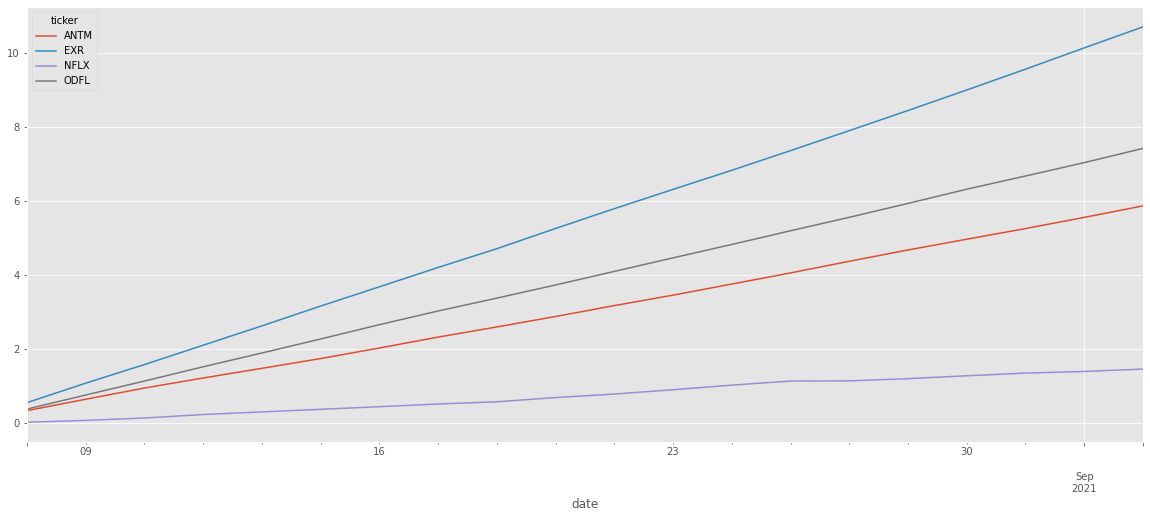

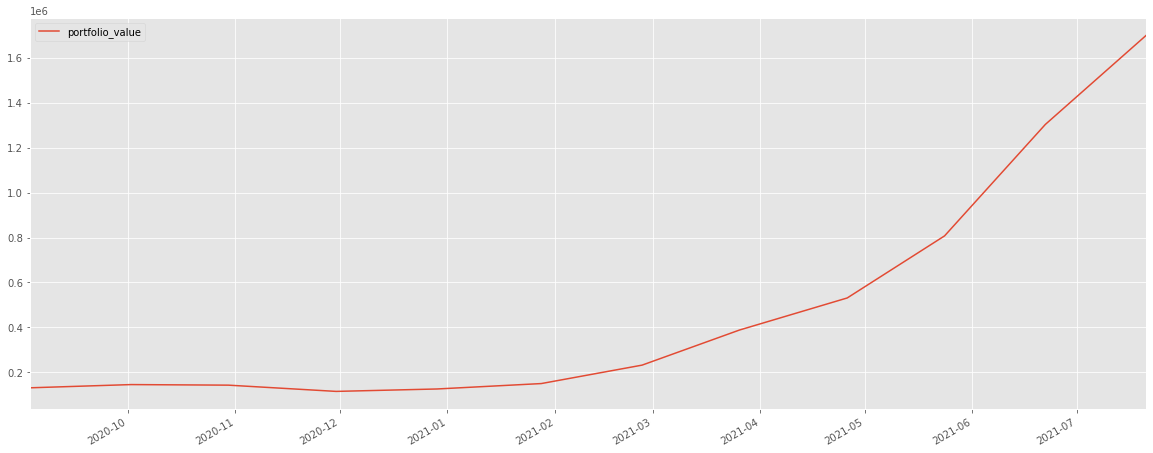

In [28]:
returns[-20:][long_weights.index.to_list()].cumsum().plot()
portfolio_growth_df = pd.DataFrame().from_dict(portfolio_growth, orient='index', columns=['portfolio_value'])
portfolio_growth_df.plot()

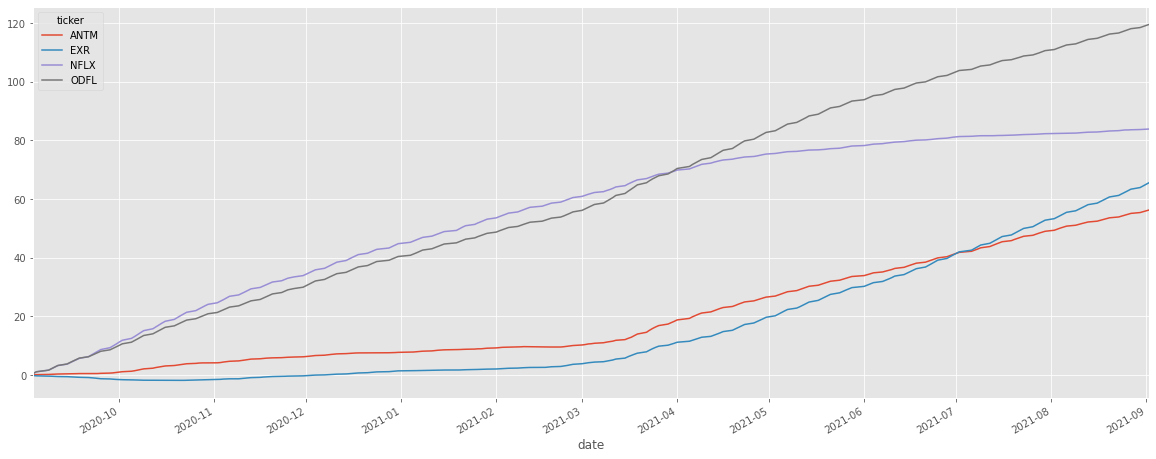

In [29]:
returns[-252:][long_weights.index.to_list()].cumsum().plot()

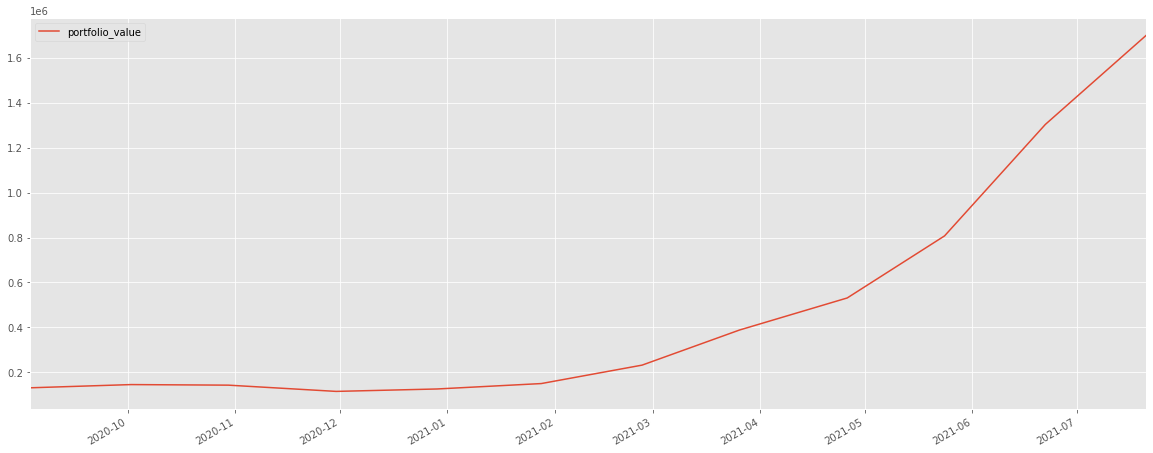

In [30]:
portfolio_growth_df = pd.DataFrame().from_dict(portfolio_growth, orient='index', columns=['portfolio_value'])
portfolio_growth_df.plot()

## Production Portfolio Optimization

Use the last day's data to determine optimal portfolio

In [31]:
opt_date = alpha_vectors.index[-1]
risk_model = daily_betas[opt_date.strftime('%m/%d/%Y')]
alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

New portfolio variance is:  0.01693852


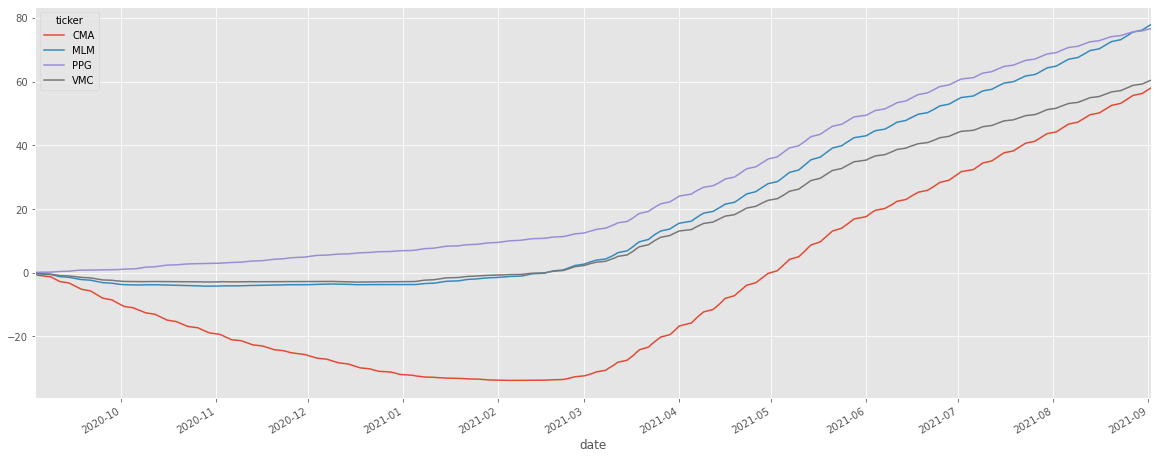

In [32]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 0]
returns[-252:][long_weights.index.to_list()].cumsum().plot()
print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [33]:
long_weights

,optimalWeights
CMA,0.33
MLM,0.01
PPG,0.33
VMC,0.33


In [34]:
investment_amount = 5000

long_quotes = amc.AmeritradeRest(username, password, client_id).get_quotes(long_weights.index.to_list())
long_holdings = (long_weights['optimalWeights'] * investment_amount).round(0)
(long_holdings / long_quotes['bidPrice'])

CMA    22.749207
MLM     0.133769
PPG    10.478852
VMC     9.166157
dtype: float64

In [35]:
long_quotes

,assetType,assetMainType,cusip,symbol,description,bidPrice,bidSize,bidId,askPrice,askSize,...,regularMarketLastPrice,regularMarketLastSize,regularMarketNetChange,regularMarketTradeTimeInLong,netPercentChangeInDouble,markChangeInDouble,markPercentChangeInDouble,regularMarketPercentChangeInDouble,delayed,realtimeEntitled
CMA,EQUITY,EQUITY,200340107,CMA,Comerica Incorporated Common Stock,72.53,100,V,72.59,1000,...,72.53,1,-0.20,1630677996344,-0.2750,-0.20,-0.2750,-0.2750,True,False
MLM,EQUITY,EQUITY,573284106,MLM,"Martin Marietta Materials, Inc. Common Stock",373.78,100,T,374.90,100,...,374.51,3,-4.92,1630677973003,-1.2967,-4.92,-1.2967,-1.2967,True,False
PPG,EQUITY,EQUITY,693506107,PPG,"PPG Industries, Inc. Common Stock",157.46,100,V,157.54,100,...,157.53,1,-1.10,1630677984465,-0.6934,-1.10,-0.6934,-0.6934,True,False
VMC,EQUITY,EQUITY,929160109,VMC,Vulcan Materials Company (Holding Company) Com...,180.01,100,T,180.27,100,...,180.29,1,-2.71,1630677972972,-1.4809,-2.73,-1.4918,-1.4809,True,False


In [36]:
long_holdings

CMA    1650.0
MLM      50.0
PPG    1650.0
VMC    1650.0
Name: optimalWeights, dtype: float64

In [37]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
parsed_and_scored_news

News Tables: 100%|████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 174.04News Table Items/s]


,ticker,date,time,headline,neg,neu,pos,compound
399,VMC,2020-12-09,06:09PM,12 Best Infrastructure Stocks to Buy Now,0.0,0.588,0.412,0.6369
398,VMC,2020-12-11,01:59PM,8 Infrastructure Stocks That Will Shine In The...,0.0,1.000,0.000,0.0000
397,VMC,2020-12-14,06:50PM,Is VMC A Good Stock To Buy Now?,0.0,0.674,0.326,0.4404
396,VMC,2020-12-18,10:10AM,"Benzinga's Top Upgrades, Downgrades For Decemb...",0.0,0.795,0.205,0.2023
395,VMC,2021-01-06,06:01AM,"Introducing Vulcan Materials (NYSE:VMC), A Sto...",0.0,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...
100,MLM,2021-09-01,11:26AM,Martin Marietta (MLM) to Acquire Ferrovial's S...,0.0,1.000,0.000,0.0000
201,PPG,2021-09-02,08:55AM,PPG Industries (PPG) to Display EV Battery Coa...,0.0,1.000,0.000,0.0000
202,PPG,2021-09-02,07:29AM,PPG To Launch PPG LINQ End-to-End Digital Solu...,0.0,0.827,0.173,0.3182
300,VMC,2021-09-02,09:33AM,5 Stocks Insiders Are Selling,0.0,1.000,0.000,0.0000


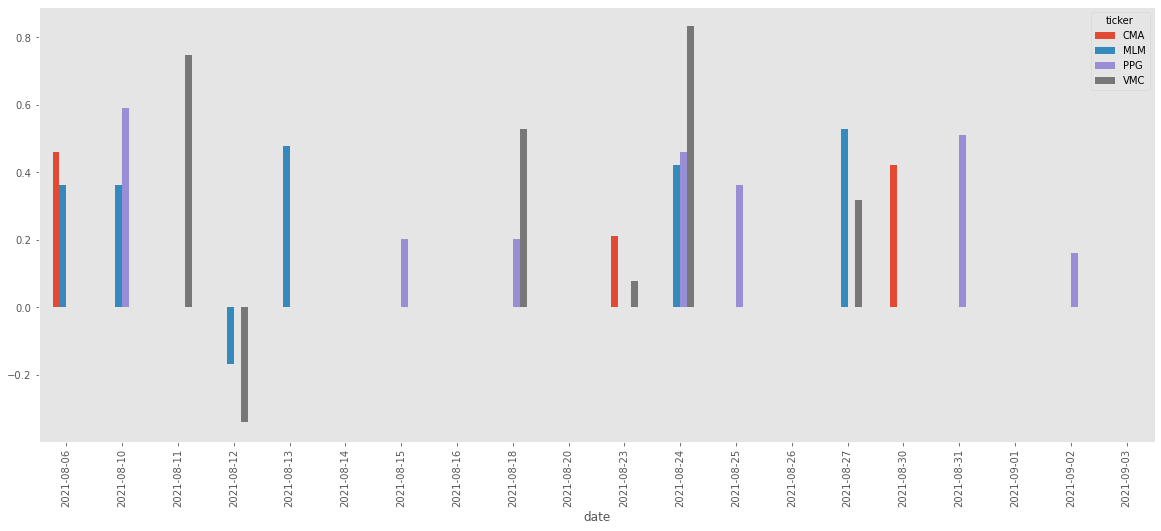

In [38]:
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] <= 0) & (optimal_weights['deltaShares'] == 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)][['deltaMarketValue', 'totalMarketValue']].sum().round(2)